# Basics of Mobile Robotics, Project report 

The final project for EPFL's [**MICRO-452: Basics of Mobile Robotics**](https://edu.epfl.ch/coursebook/en/basics-of-mobile-robotics-MICRO-452) course. This project implements a complete navigation stack for a differential drive robot, featuring computer vision, graph-based path planning, sensor fusion (EKF), and reactive control.

**The Concept:** Inspired by the Disney movie WALL·E, the robot EVE must navigate through the interior of the spaceship Axiom - a complex and hazardous environment. Her mission is to reach, her love,  WALL·E as fast as possible, while avoiding a series of dangerous obstacles.
The map includes:

- Windows: Represented as static dark-blue polygonal regions that EVE must not cross. These areas act as boundaries or fatal zones, similar to voids in the spacecraft’s structure.

- Humans (“Passengers”): Large, drifting individuals who move unpredictably through the corridors. They function as dynamic obstacles that EVE must detect and avoid in real time.

![Example environment](../vision_debug/warped.jpg)


## Group members & tasks repartition
- Tancrede Lamort De Gail: Vision, global navigation, motion control
- John Constantin: Vision, global navigation, motion control
- Marcus Edjolo: Local naviation, global navigation, motin control
- Yvan Barragan: Filtering, motion control


## 1. Physical Setup

The project tasks a Thymio II robot with navigating from a start pose to a goal pose while avoiding two distinct types of obstacles.

### 1.1 The Environment

The playground consist of a white rectangle of 130x92 cm delimitated by four Aruco Marker place on each of the 4 corners.

The environment presents a dual-layer challenge:

1.  **Static "Global" Obstacles (The Windows):**
    -   **Physicality:** Flat, dark blue polygonal cutouts.
    -   **Visibility:** _Invisible_ to the robot's onboard horizontal proximity sensors, but clearly visible to the overhead global camera.
    -   **Constraint:** The robot cannot drive over them. Avoiding them relies entirely on accurate global localization and path planning.
2.  **Ephemeral "Local" Obstacles (The Passengers):**
    -   **Physicality:** 3D physical objects (cylinders, blocks) roughly the size of the robot.
    -   **Visibility:** Visible to the robot's onboard sensors, but _ignored_ by the global camera mapping (or placed after mapping is complete).
    -   **Constraint:** These act as dynamic blockers. The robot must use local sensing to reactively avoid them without losing track of its global objective.

### 1.2 The Robot

The **Thymio II** is a differential-drive mobile robot.

-   **Sensors:** 5 front-facing and 2 rear-facing horizontal IR proximity sensors (for local avoidance).
-   **Comms:** Python API interfacing via USB/RF dongle.
-   **Markers:** An ArUco marker is mounted on top of the robot to facilitate high-precision global tracking (Pose: $x, y, \theta$) via the overhead camera.

### 1.3 The Camera

We're usging our smartphone mounted overhead to have a better quality and beging less sentistive to the environment. With the software "Camo studio" we are able the read the phone camera at $1920 \times 1080$, RGB, 30 FPS and transmit to the program.



## 2. Vision System
The vision systeme serves as the "GPS" of the system, responsible for:

1.  **Initial Mapping:** Detecting static obstacle polygons and the goal area.
2.  **Live Tracking:** Providing absolute position estimates to correct the robot's drifting odometry.


### 2.1 System Architecture

The vision pipeline operates in two distinct phases:

#### 2.1.1 Initialization Phase (Static Mapping)
During startup, the system captures a single reference frame and extracts the complete static environment:
- Calibration markers define the workspace boundaries
- Static obstacles (the "spacecraft windows") are segmented and converted to polygonal representations
- Goal location (WALL·E's position) is identified
- Visibility graph is pre-computed for path planning

#### 2.1.2 Runtime Phase (Real-Time Localization)
During navigation, the system continuously:
- Captures frames at approximately 10 Hz
- Detects (EVE's position) the robot's ArUco marker
- Computes the robot's pose $(x, y, \theta)$
- Provides measurements to the Extended Kalman Filter for sensor fusion

### 2.2 Coordinate Systems and Perspective Transformation

The vision system must bridge two distinct coordinate frames:

**Camera Frame:** The raw image captured by the overhead camera, measured in pixels with origin at top-left, where coordinates are $(u, v) \in [0, 1920] \times [0, 1080]$.

**World Frame:** The robot's navigation space, measured in centimeters with origin at bottom-left of the workspace, where coordinates are $(x, y) \in [0,132.5 ] \times [0, 92.5]$.

#### 2.2.1 Perspective Correction

Due to the camera's mounting angle and lens distortion, the raw image exhibits perspective distortion. We use a **homography transformation** to warp the image into an orthographic (bird's-eye) view:

$$
\begin{bmatrix} u' \\ v' \\ w \end{bmatrix} = \mathbf{H} \begin{bmatrix} u \\ v \\ 1 \end{bmatrix}
$$

where $\mathbf{H} \in \mathbb{R}^{3 \times 3}$ is the perspective transformation matrix computed via OpenCV's `getPerspectiveTransform()` using the four corner calibration markers as control points.

The final pixel coordinates after perspective correction are:
$$
x_{\text{px}} = \frac{u'}{w}, \quad y_{\text{px}} = \frac{v'}{w}
$$

#### 2.2.2 Metric Conversion

After warping, we convert from the rectified pixel space to world coordinates (cm):

$$
x_{\text{cm}} = \frac{x_{\text{px}}}{\alpha_x}, \quad y_{\text{cm}} = H_{\text{map}} - \frac{y_{\text{px}}}{\alpha_y}
$$

where:
- $\alpha_x = \frac{W_{\text{px}}}{W_{\text{cm}}}$ and $\alpha_y = \frac{H_{\text{px}}}{H_{\text{cm}}}$ are pixel-to-centimeter scaling factors
- $H_{\text{map}}$ is the map height (flipping y-axis from image convention)


### 2.3 Environment Segmentation

#### 2.3.1 Color-Based Segmentation
We segment obstacles and the goal using **HSV color space** thresholding (finding experimentally), which is more robust to lighting variations than RGB:

**Static Obstacles (Dark Blue):**
$$
\text{Mask}_{\text{obstacle}} = \{(h,s,v) \mid 90° \leq h \leq 165°, \, 40 \leq s \leq 255, \, 80 \leq v \leq 255\}
$$

**Goal Region (Red):**
Due to red's wraparound in HSV (0° and 360° are both red), we use a dual-range mask:
$$
\text{Mask}_{\text{goal}} = \text{Mask}_{\text{red1}} \cup \text{Mask}_{\text{red2}}
$$
where:
- $\text{Mask}_{\text{red1}}: 0° \leq h \leq 15°$
- $\text{Mask}_{\text{red2}}: 165° \leq h \leq 180°$


#### 2.3.2 Morphological Filtering
To eliminate noise and fill gaps in the segmented regions, we apply morphological operations with a $7 \times 7$ kernel:
1. **Opening** (erosion → dilation): Removes small noise blobs
2. **Closing** (dilation → erosion): Fills internal holes in obstacles

<div style="display: flex; gap: 20px; justify-content: center; align-items: flex-start;">

  <figure style="margin: 0; text-align: center;">
    <img src="../vision_debug/obstacle_mask.jpg" alt="Obstacle mask" width="300"/>
    <figcaption>Obstacle mask</figcaption>
  </figure>

  <figure style="margin: 0; text-align: center;">
    <img src="../vision_debug/target_mask.jpg" alt="Target mask" width="300"/>
    <figcaption>Target mask</figcaption>
  </figure>
</div>


### 2.4 Configuration Space Construction

#### 2.4.1 Polygon Approximation
Raw contours from segmentation are noisy and contain hundreds of vertices. We simplify them using the **Douglas-Peucker algorithm**:

$$
\epsilon = 0.015 \cdot \text{arcLength}(\text{contour})
$$

This produces polygons with 4-12 vertices while preserving essential shape features.

#### 2.4.2 C-Space Inflation
To account for the robot's physical dimensions, we **buffer** each obstacle polygon by the robot's radius plus a safety margin:

$$
\mathcal{O}_{\text{buffered}} = \mathcal{O} \oplus B_r
$$

where:
- $\mathcal{O}$ is the original obstacle polygon
- $B_r$ is a disk of radius $r = r_{\text{robot}} + \text{padding}$ (≈ 5.5 cm)
- $\oplus$ denotes Minkowski sum (implemented via Shapely's `buffer()` with mitre join style)

This operation effectively reduces the robot to a point in configuration space, simplifying collision checking.

#### 2.4.3 Vertex Merging
The buffering operation can introduce redundant vertices on long straight edges. To reduce graph complexity, we merge vertices closer than a threshold $d_{\text{min}} = 6.0$ cm:

$$
\text{if } \|v_i - v_{i+1}\| < d_{\text{min}}, \quad v_{\text{merged}} = \frac{v_i + v_{i+1}}{2}
$$

### 2.5 Configuration Space Construction

#### 2.5.1 Polygon Approximation
Raw contours from segmentation are noisy and contain hundreds of vertices. We simplify them using the **Douglas-Peucker algorithm**:

$$
\epsilon = 0.015 \cdot \text{arcLength}(\text{contour})
$$

This produces polygons with 4-12 vertices while preserving essential shape features.

#### 2.5.2 C-Space Inflation
To account for the robot's physical dimensions, we **buffer** each obstacle polygon by the robot's radius plus a safety margin:

$$
\mathcal{O}_{\text{buffered}} = \mathcal{O} \oplus B_r
$$

where:
- $\mathcal{O}$ is the original obstacle polygon
- $B_r$ is a disk of radius $r = r_{\text{robot}} + \text{padding}$ (≈ 5.5 cm)
- $\oplus$ denotes Minkowski sum (implemented via Shapely's `buffer()` with mitre join style)

This operation effectively reduces the robot to a point in configuration space, simplifying collision checking.

#### 2.5.3 Vertex Merging
The buffering operation can introduce redundant vertices on long straight edges. To reduce graph complexity, we merge vertices closer than a threshold $d_{\text{min}} = 6.0$ cm:

$$
\text{if } \|v_i - v_{i+1}\| < d_{\text{min}}, \quad v_{\text{merged}} = \frac{v_i + v_{i+1}}{2}
$$

### 2.6 Visibility Graph Construction

The visibility graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ encodes all collision-free straight-line paths through the environment. We leverage two Python libraries for this task: **Shapely** for geometric operations (polygon intersection, line-polygon collision detection) and **NetworkX** for graph representation and manipulation.

#### 2.6.1 Node Addition
We begin by constructing the node set $\mathcal{V}$, which includes all vertices from the buffered obstacle polygons plus the goal location:

$$
\mathcal{V} = \mathcal{V}_{\text{obstacles}} \cup \{v_{\text{goal}}\}
$$

Each node $v_i$ is added to a NetworkX graph with an attribute `pos` storing its $(x, y)$ coordinates in centimeters.

#### 2.6.2 Obstacle Edge Insertion
Before computing visibility between arbitrary node pairs, we first add all **obstacle boundary edges** to the graph. For each obstacle polygon with vertices $\{v_0, v_1, \ldots, v_{n-1}\}$, we connect consecutive vertices:

_________________________________________________________
$$
\mathcal{E}_{\text{obstacle}} = \{(v_i, v_{i+1 \mod n}) \mid i = 0, \ldots, n-1\}
$$

Each edge is weighted by Euclidean distance:
$$
w(v_i, v_j) = \|v_i - v_j\|_2 = \sqrt{(x_j - x_i)^2 + (y_j - y_i)^2}
$$

This ensures that paths can traverse obstacle perimeters when necessary.
_____________________________________________________________
#### 2.6.3 Visibility Edge Computation
Next, we test visibility between all pairs of nodes. Two nodes $v_i, v_j$ are connected by an edge if:
1. They are not already connected (to avoid duplicate obstacle edges)
2. The line segment $\overline{v_i v_j}$ does not intersect any obstacle interior

We implement visibility checking using Shapely's geometric predicates. The test verifies that the line segment neither crosses through nor lies entirely within any obstacle:

$$
\text{visible}(v_i, v_j) = \begin{cases}
\text{True} & \text{if } \overline{v_i v_j} \cap \mathcal{O}_k = \emptyset \, \forall k \text{ and } \overline{v_i v_j} \not\subset \mathcal{O}_k \, \forall k \\
\text{False} & \text{otherwise}
\end{cases}
$$

The second condition is critical for concave obstacles - a line segment could lie entirely within a U-shaped obstacle without technically "intersecting" its boundary.

**Shrinking Heuristic:** To avoid false positives from floating-point precision issues at polygon vertices, we test a **slightly shortened** version of each line segment:

$$
\overline{v_i v_j}_{\text{test}} = \{v_i + 0.001 \cdot (v_j - v_i) \to v_i + 0.999 \cdot (v_j - v_i)\}
$$

This prevents spurious intersections when paths graze obstacle corners.

#### 2.6.4 Boundary Cropping
After constructing the full graph, we perform a final validation step: **remove any nodes that lie outside the map boundaries**. Due to the buffering operation, some obstacle vertices may extend beyond the physical workspace limits $[0, W_{\text{map}}] \times [0, H_{\text{map}}]$.

We identify and remove all such nodes:
$$
\mathcal{V}_{\text{invalid}} = \{v_i \in \mathcal{V} \mid x_i < 0 \text{ or } x_i > W_{\text{map}} \text{ or } y_i < 0 \text{ or } y_i > H_{\text{map}}\}
$$

$$
\mathcal{V}_{\text{final}} = \mathcal{V} \setminus \mathcal{V}_{\text{invalid}}
$$

NetworkX automatically removes all edges connected to deleted nodes, ensuring graph integrity.

#### 2.6.5 Base Graph Storage
The result of this process is the **base visibility graph**, which contains only obstacle vertices and the goal node. This graph is computed once during initialization and stored as `self.base_graph`. The robot's start position is intentionally excluded at this stage to enable dynamic replanning after kidnapping events.

### 2.7 Dynamic Graph Augmentation

Since the robot's start position changes after each kidnapping event, the visibility graph must be **dynamically updated**:

1. **Base Graph:** Contains only obstacle vertices and the goal (precomputed once)
2. **Runtime Augmentation:** When the robot is relocated:
   - Add a new start node $v_{\text{start}}$ at the robot's current pose
   - Test visibility from $v_{\text{start}}$ to all existing nodes
   - Connect $v_{\text{start}}$ to all visible nodes with weighted edges
   - Run A* search on the augmented graph

This strategy avoids recomputing the entire $O(n^3)$ visibility graph (where $n \approx 40$ nodes) after every kidnapping - we only perform $O(n^2)$ visibility tests from the new start node.

### 2.8 ArUco Marker Detection and Pose Estimation

#### 2.8.1 Pose Computation
Given the four corners of the detected marker $\{C_0, C_1, C_2, C_3\}$ (ordered as Top-Left, Top-Right, Bottom-Right, Bottom-Left), we compute:

**Position** (centroid):
$$
x = \frac{1}{4}\sum_{i=0}^{3} C_{i,x}, \quad y = \frac{1}{4}\sum_{i=0}^{3} C_{i,y}
$$

**Orientation** (from marker's left edge):
$$
\theta = \text{atan2}(C_{0,y} - C_{3,y}, \, C_{0,x} - C_{3,x})
$$

This orientation vector points along the robot's forward direction, as the marker is mounted with its left edge aligned with the robot's heading.

### 2.8 Measurement Uncertainty

The camera provides pose estimates $(x, y, \theta)$ with empirically measured covariance:

$$
\mathbf{R}_{\text{camera}} = \begin{bmatrix}
0.00119 & 0 & 0 \\
0 & 0.00179 & 0 \\
0 & 0 & 0.000061
\end{bmatrix}
$$

This translates to standard deviations of approximately:
- Position: $\sigma_x \approx 3.4$ mm, $\sigma_y \approx 4.2$ mm
- Orientation: $\sigma_\theta \approx 0.45°$

These values were obtained through repeated measurements of a stationary robot and used to tune the Extended Kalman Filter.

 

# 3. Path Planning

Once the vision system has constructed a visibility graph of the environment, the robot needs to compute the shortest collision-free path from its current position to the goal. We implement this using the **A\* (A-star) search algorithm**.

## 3.1 The A\* Algorithm

A\* is an informed search algorithm that explores the graph by expanding nodes with the lowest estimated total cost. For each node $n$, it maintains:

$$
f(n) = g(n) + h(n)
$$

where:
- $g(n)$: **Actual cost** from the start node to $n$ (sum of edge weights along the path)
- $h(n)$: **Heuristic estimate** of cost from $n$ to the goal
- $f(n)$: **Estimated total cost** of the path through $n$

### 3.1.1 Admissibility and Optimality

For A\* to guarantee finding the shortest path, the heuristic must be **admissible** (never overestimate the true cost). We use **Euclidean distance** as our heuristic:

$$
h(n) = \|p_n - p_{\text{goal}}\|_2 = \sqrt{(x_{\text{goal}} - x_n)^2 + (y_{\text{goal}} - y_n)^2}
$$

This is admissible because straight-line distance is always less than or equal to any path through obstacles. Additionally, since all edge weights in our graph are Euclidean distances (a consistent metric), A\* will expand each node at most once.

### 3.1.2 Algorithm Structure

The implementation uses a **priority queue** (min-heap) to efficiently retrieve the node with the lowest $f$-cost at each iteration:

1. **Initialization:**
   - Add start node to the open set with $f(start) = h(start)$
   - Set $g(start) = 0$ and $g(n) = \infty$ for all other nodes

2. **Main Loop:**
   ```
   while open_set is not empty:
       current ← node with lowest f(current)
       
       if current == goal:
           return reconstruct_path()
       
       for each neighbor of current:
           tentative_g = g(current) + weight(current, neighbor)
           
           if tentative_g < g(neighbor):
               parent[neighbor] = current
               g(neighbor) = tentative_g
               f(neighbor) = g(neighbor) + h(neighbor)
               add neighbor to open_set
   ```

3. **Path Reconstruction:**
   Once the goal is reached, backtrack through the `parent` pointers from goal to start, then reverse the list to obtain the path in start→goal order.

### 3.1.3 Implementation Details

**Lazy Deletion:** Python's `heapq` module does not support priority updates. Instead, when we find a better path to a node already in the queue, we simply add a new entry with the improved $f$-cost. The old entry remains in the heap but will be ignored when popped (since its $g$-cost will be worse than the recorded value).

**NetworkX Integration:** Our visibility graph is stored as a `networkx.Graph` object where:
- Nodes have attribute `pos: Point` (world coordinates)
- Edges have attribute `weight: float` (Euclidean distance)

This abstraction allows A\* to operate independently of the graph construction method.

## 3.2 Waypoint Generation

The output of A\* is a sequence of node indices:
$$
\text{path} = [n_{\text{start}}, n_1, n_2, \ldots, n_{k-1}, n_{\text{goal}}]
$$

We convert these to world-space waypoints by extracting the `pos` attribute:
$$
\text{waypoints} = [(x_0, y_0), (x_1, y_1), \ldots, (x_k, y_k)]
$$

The controller then navigates sequentially through these waypoints, moving to the next one once within a threshold distance (3 cm) of the current target.

---



# 4. Local Navigation and Control

While the vision system and path planner provide a global roadmap, the robot must execute this plan in the real world using onboard sensors and actuators. This layer handles two critical tasks: (1) **waypoint tracking** - following the planned path, and (2) **reactive obstacle avoidance** - responding to dynamic obstacles not captured during mapping.

## 4.1 Control Architecture

The control system operates as a **hierarchical state machine** with three states:

### 4.1.1 State: NAVIGATING
**Objective:** Drive toward the current waypoint.

**Control Law:** Proportional control on heading error with speed regulation based on alignment:

$$
\begin{align}
\theta_{\text{error}} &= \text{normalize}\left(\text{atan2}(y_{\text{target}} - y, x_{\text{target}} - x) - \theta\right) \\
\omega &= K_p \cdot \theta_{\text{error}} \\
v &= v_{\max} \cdot \max(0, \cos(\theta_{\text{error}}))
\end{align}
$$

where:
- $K_p = 120$ is the proportional gain for angular velocity
- $v_{\max} = 125$ Thymio units (≈ 14 cm/s)
- $\text{normalize}(\cdot)$ wraps angles to $[-\pi, \pi]$

The cosine term elegantly handles the speed-accuracy tradeoff: when the robot is well-aligned with the target ($\theta_{\text{error}} \approx 0$), it drives at full speed. When misaligned ($|\theta_{\text{error}}| \approx \pi/2$), it stops forward motion and rotates in place.

**Differential Drive Kinematics:**
$$
\begin{align}
v_L &= v - \omega \\
v_R &= v + \omega
\end{align}
$$

### 4.1.2 State: AVOIDING
**Trigger:** Any front proximity sensor exceeds threshold (400 units ≈ 4 cm).

**Objective:** Steer away from obstacle using a Braitenberg-inspired reactive controller.

**Control Law:**
$$
\tau = w_{\text{outer}}(s_0 - s_4) + w_{\text{inner}}(s_1 - s_3)
$$

where:
- $s_i$ are the five front proximity sensor readings (indexed left to right)
- $w_{\text{outer}} = 1.0$, $w_{\text{inner}} = 1.7$ are tuned weights
- $\tau$ is the turn bias (positive = turn right, negative = turn left)

The motor commands become:
$$
\begin{align}
v_L &= v_{\text{avoid}} + k \cdot \tau \\
v_R &= v_{\text{avoid}} - k \cdot \tau
\end{align}
$$

with gain $k = 0.025$.

**Adaptive Weighting:** If the left-right sensor difference is too small ($|s_1 - s_3| < 30$), indicating a symmetric frontal obstacle, we disable the inner sensors and increase outer weights to $w_{\text{outer}} = 2.3$ to encourage a sharper turn.

### 4.1.3 State: RETURN (Decay Phase)
**Trigger:** Obstacle clears while in AVOIDING state.

**Objective:** Smoothly transition back to waypoint tracking without abrupt commands.

For duration $T = 4.0$ seconds after obstacle clearance, we **blend** the "drive straight" behavior with the waypoint navigation:

$$
\begin{align}
\alpha(t) &= \max\left(0, 1 - \frac{t}{T}\right) \quad \text{(decay factor)} \\
v_L &= \alpha \cdot v_{\max} + (1 - \alpha) \cdot v_{L,\text{nav}} \\
v_R &= \alpha \cdot v_{\max} + (1 - \alpha) \cdot v_{R,\text{nav}}
\end{align}
$$

where $v_{L/R,\text{nav}}$ are the outputs from the waypoint tracking controller. This linear interpolation prevents oscillations and ensures the robot smoothly reorients toward the path.

## 4.2 Waypoint Advancement

The robot monitors its distance to the current waypoint:
$$
d = \sqrt{(x_{\text{waypoint}} - x)^2 + (y_{\text{waypoint}} - y)^2}
$$

When $d < 3.0$ cm (approximately the robot's radius), the waypoint is considered reached and the controller advances to the next one in the sequence.

## 4.3 Design Rationale

**Why State Machine?** Finite state machines provide predictable, debuggable behavior. Each state has a clear purpose and explicit transition conditions.

**Why Decay Phase?** Instantaneous switching from obstacle avoidance back to navigation causes "chattering" - the robot oscillates between states when near an obstacle. The decay phase acts as a low-pass filter on the control commands.

**Why Braitenberg?** While not globally optimal, Braitenberg controllers are computationally trivial (no planning required) and provide robust local reflexes. They complement global planning by handling unforeseen obstacles.

---

# 5. State Estimation: Extended Kalman Filter

The robot has two sources of position information: (1) **odometry** from wheel encoders (high-frequency, but drifts over time), and (2) **camera measurements** from the overhead vision system (accurate but lower frequency and occasionally unavailable). An **Extended Kalman Filter (EKF)** fuses these complementary sources into a single, optimal pose estimate.

## 5.1 The State Vector

The robot's state is represented as:
$$
\mathbf{x} = \begin{bmatrix} x \\ y \\ \theta \end{bmatrix}
$$

where $(x, y)$ is the position in centimeters and $\theta$ is the heading in radians. The EKF maintains:
- $\mathbf{x}$: Current state estimate
- $\mathbf{P} \in \mathbb{R}^{3 \times 3}$: State covariance matrix (uncertainty)

## 5.2 Motion Model (Prediction Step)

The robot's motion follows the standard **unicycle model** for differential drive robots:

$$
\begin{align}
\dot{x} &= \frac{v_L + v_R}{2} \cos(\theta) \\
\dot{y} &= \frac{v_L + v_R}{2} \sin(\theta) \\
\dot{\theta} &= \frac{v_R - v_L}{L}
\end{align}
$$

where $L = 9.5$ cm is the wheelbase and $v_{L/R}$ are the left/right wheel velocities measured from motor encoder feedback.

### 5.2.1 Discrete-Time Propagation

At each timestep $\Delta t \approx 0.1$ s, we propagate the state using Euler integration:

$$
\mathbf{x}_{k+1} = f(\mathbf{x}_k, \mathbf{u}_k) = \begin{bmatrix}
x_k + v \cos(\theta_k) \Delta t \\
y_k + v \sin(\theta_k) \Delta t \\
\theta_k + \omega \Delta t
\end{bmatrix}
$$

where $v = (v_L + v_R)/2$ and $\omega = (v_R - v_L)/L$.

### 5.2.2 Jacobian Computation

Since the motion model is nonlinear (due to trigonometric functions), we linearize it around the current state estimate:

$$
\mathbf{F}_k = \frac{\partial f}{\partial \mathbf{x}}\bigg|_{\mathbf{x}_k} = \begin{bmatrix}
1 & 0 & -v \sin(\theta_k) \Delta t \\
0 & 1 & v \cos(\theta_k) \Delta t \\
0 & 0 & 1
\end{bmatrix}
$$

### 5.2.3 Process Noise

Wheel slip, uneven surfaces, and encoder quantization introduce uncertainty in the motion. We model this as additive Gaussian noise $\mathbf{w}_k \sim \mathcal{N}(\mathbf{0}, \mathbf{Q}_k)$ where the process noise covariance is computed dynamically based on wheel speeds (higher speeds → higher uncertainty).

**Prediction equations:**
$$
\begin{align}
\hat{\mathbf{x}}_{k+1}^{-} &= f(\hat{\mathbf{x}}_k, \mathbf{u}_k) \\
\mathbf{P}_{k+1}^{-} &= \mathbf{F}_k \mathbf{P}_k \mathbf{F}_k^T + \mathbf{Q}_k
\end{align}
$$

where the superscript $(-)$ denotes the *a priori* estimate before incorporating measurements.

## 5.3 Measurement Model (Update Step)

The overhead camera directly observes all three state variables, giving the measurement equation:

$$
\mathbf{z}_k = \mathbf{H} \mathbf{x}_k + \mathbf{v}_k
$$

where:
- $\mathbf{H} = \mathbf{I}_{3 \times 3}$ (identity matrix, since we measure $x$, $y$, $\theta$ directly)
- $\mathbf{v}_k \sim \mathcal{N}(\mathbf{0}, \mathbf{R})$ is measurement noise with covariance:

$$
\mathbf{R} = \begin{bmatrix}
0.00119 & 0 & 0 \\
0 & 0.00179 & 0 \\
0 & 0 & 0.000061
\end{bmatrix}
$$

This covariance was empirically determined (see Section 2.8).

### 5.3.1 Kalman Gain

The Kalman gain determines how much to trust the measurement vs. the prediction:

$$
\mathbf{K}_k = \mathbf{P}_k^{-} \mathbf{H}^T \left(\mathbf{H} \mathbf{P}_k^{-} \mathbf{H}^T + \mathbf{R}\right)^{-1}
$$

When $\mathbf{P}_k^{-}$ is large (high prediction uncertainty), $\mathbf{K}_k$ is large → trust measurement more.
When $\mathbf{R}$ is large (noisy measurement), $\mathbf{K}_k$ is small → trust prediction more.

### 5.3.2 State Correction

$$
\begin{align}
\hat{\mathbf{x}}_k &= \hat{\mathbf{x}}_k^{-} + \mathbf{K}_k (\mathbf{z}_k - \mathbf{H} \hat{\mathbf{x}}_k^{-}) \\
\mathbf{P}_k &= (\mathbf{I} - \mathbf{K}_k \mathbf{H}) \mathbf{P}_k^{-} (\mathbf{I} - \mathbf{K}_k \mathbf{H})^T + \mathbf{K}_k \mathbf{R} \mathbf{K}_k^T
\end{align}
$$

The second equation uses the **Joseph form** for numerical stability, ensuring $\mathbf{P}_k$ remains positive definite.

## 5.4 Asynchronous Measurement Handling

The camera does not always provide measurements (e.g., when the ArUco marker is occluded or the robot moves too fast causing motion blur). The EKF handles this gracefully:

- **Every control cycle (10 Hz):** Run prediction step using odometry
- **When camera data arrives:** Run update step to correct the estimate
- **When camera unavailable:** Skip update step; rely purely on odometry (uncertainty $\mathbf{P}$ grows)

This architecture allows the filter to continue operating even with intermittent measurements.

## 5.5 Kidnap Detection and Recovery

The original EKF implementation included a **kidnap detector** based on position jumps:

$$
\text{if } \|\mathbf{z}_k^{xy} - \hat{\mathbf{x}}_k^{-,xy}\| > 30 \text{ cm} \implies \text{Reject measurement (kidnap)}
$$

However, this was **disabled** in the final system in favor of a hardware-based approach using **ground sensors**. The proximity sensors on the robot's underside detect when the robot is lifted (reflected signal drops dramatically). When detected, the main control loop:

1. Stops all motors
2. Enters KIDNAPPED state
3. Waits for robot to be placed back down (ground sensor signal returns)
4. Waits 2 seconds for stabilization
5. Requests a new camera measurement
6. **Resets EKF** with new measurement as initial state: $\hat{\mathbf{x}}_0 = \mathbf{z}_{\text{camera}}$, $\mathbf{P}_0 = \mathbf{R}$
7. Triggers path replanning from new location

This approach is more reliable than jump detection since large position changes can occur legitimately when the camera briefly loses tracking.

---

**Key Advantages of EKF:**
- **Sensor Fusion:** Combines high-rate odometry with accurate but sparse camera measurements
- **Uncertainty Quantification:** Provides not just a position estimate but also confidence bounds
- **Predictive Capability:** Can estimate position even when measurements are unavailable
- **Optimal (for linear systems):** Minimizes mean squared error when assumptions hold

## 🔬 Filtering (EKF) [To modify bc I didnt read the code enough yet]

This module provides a smooth and accurate estimate of the robot's pose by fusing the noisy odometry model with the noisy vision measurements.

### Theory: Extended Kalman Filter (EKF)

The EKF is necessary because the robot's motion model (kinematics) and the vision measurements are both subject to noise. Furthermore, the robot's motion is governed by non-linear equations (due to the $\sin(\theta)$ and $\cos(\theta)$ terms), requiring the use of the Extended version of the Kalman Filter.

The EKF proceeds in two steps per cycle:

1.  **Prediction (Time Update):** Uses the robot's kinematic model ($\text{Thymio.state\_extrapolation\_f}$) to project the current pose ($\hat{x}_{k-1}$) and covariance ($\hat{P}_{k-1}$) forward in time, accounting for the process noise ($Q$).
2.  **Update (Measurement Update):** Corrects the predicted pose ($\bar{x}_k$) using the measurement ($\text{z}_k$) from the vision system, weighted by the Kalman Gain ($K$).

### Kinematic Model and Noise ($\text{thymio\_math\_model.py}$)

The $\text{Thymio}$ class defines the differential-drive kinematic equations and computes the Process Noise Covariance matrix ($Q$).

* **Process Noise ($Q$):** $Q$ is calculated dynamically using the Jacobian ($G$) of the state transition function with respect to the input (wheel speeds, $v_l, v_r$).
    $$Q = G \Sigma_u G^T + Q_{\text{model}}$$
    The input covariance $\Sigma_u$ accounts for noise proportional to the wheel speed: $\text{var}(v) \propto |u|$, which is essential for realistic noise modeling in small robots.
* **Parameters:** The constants $L$ ($9.5 \text{ cm}$ axle length), $R$ ($2.2 \text{ cm}$ wheel radius), and the noise scaling factors ($\text{kvl} = 0.47, \text{kvr} = 0.51$) were obtained through physical measurements and empirical data analysis of the Thymio.

#### Code: EKF Initialization

```python
# CODE FROM state_estimation.py and thymio_math_model.py
import numpy as np
from utils import Pose
# ... (rest of state_estimation.py and thymio_math_model.py content)

## ⚙️ Motion Control Module Implementation

The robot's motion control is executed by the ThymioController class, which operates as a **Finite State Machine (FSM)**. This structure allows for seamless and stable arbitration between global, goal-oriented driving and local, reactive obstacle avoidance.

---

### 1. FSM and Control Strategy: Blending and Stability

#### Theory: FSM with Time-Based Control Blending

The core design principle is the use of a time-based blending mechanism when transitioning from the AVOIDING state back to NAVIGATING. This technique is a critical engineering choice to prevent control signal instability (overshooting or oscillation) upon re-entry to the complex proportional goal-seeking behavior.

The transition is governed by a fixed-duration cooldown phase (AVOIDANCE_DURATION = $\mathbf{4.0\text{ s}}$). During this time, the output motor commands are a linear interpolation between the stable, simple command (Drive Straight) and the complex navigation command (Move to Point).

The blending factor, $\text{decay}$, ensures a smooth ramp-down of the straight-drive influence:
$$\text{Command} = \text{decay} \cdot \text{Drive}_{\text{Straight}} + (1.0 - \text{decay}) \cdot \text{Command}_{\text{Navigate}}$$
where $\text{decay} \to 1.0$ at the start of the cooldown and $\text{decay} \to 0.0$ at the end.

#### Choices and Justification

* Fixed Cooldown Duration ($\mathbf{4.0\text{ s}}$): This fixed time, rather than a proportional distance or angular correction, was chosen for its robustness in the constrained Thymio environment. It guarantees sufficient time for the robot to clear the immediate disturbance and for the external pose estimation system to provide settled, stable data.
* Avoidance Threshold ($\mathbf{400}$): This low $\text{SENSOR\_THRESHOLD}$ was selected to trigger avoidance preemptively (at a greater distance). Early reaction is preferred to aggressive, late braking, especially given the high $\text{AVOID\_SPEED}$ ($\mathbf{125.0}$).

---

### 2. Goal-Oriented Driving: $\text{\_move\_to\_point()}$

This module forms the core of the NAVIGATING state, calculating the motor commands required to eliminate the angular error relative to the next global waypoint.

#### Theory: P-Controller with Regulated Linear Speed

The controller uses a Proportional (P) Controller for angular control, coupled with a regulated linear speed function based on the $\cos$ of the heading error.

* Angular Control ($\omega$): $\omega$ is proportional to the $\text{heading\_error}$ ($\omega = \text{KP\_ROT} \times \text{heading\_error}$).
* Linear Speed ($V$): $V$ is attenuated by $\max(0.0, \cos(\text{heading\_error}))$. This design ensures the robot slows down when it needs to make large turning corrections (i.e., when $\text{heading\_error}$ approaches $\pm 90^\circ$), resulting in a stable, efficient turn-in-place maneuver instead of a large arcing path.

#### Parameter Tuning

| Parameter | Value | Rationale for Choice |
| :--- | :--- | :--- |
| $\text{KP\_ROT}$ | $\mathbf{120.0}$ | A high proportional gain, empirically tuned for quick, decisive steering with minimal oscillation around the target heading. |
| $\text{MAX\_SPEED}$ | $\mathbf{125.0}$ | Set high to ensure high path efficiency when driving straight, matching the $\text{AVOID\_SPEED}$. |

---

### 3. Reactive Avoidance: $\text{\_avoid\_obstacles()}$

This function generates the motor commands during the AVOIDING state, taking over path following to prevent collision with a local obstacle.

#### Theory: Differential Steering with Dynamic Weighting

The avoidance mechanism is a differential steering technique where the $\text{turn}_{\text{weight}}$ is derived from the weighted sensor inputs.

A key design innovation is the use of dynamic sensor weighting based on the symmetry of the frontal threat:

$$\text{turn}_{\text{weight}} = (S_0 \cdot W_{\text{outer}} + S_1 \cdot W_{\text{inner}}) - (S_3 \cdot W_{\text{inner}} + S_4 \cdot W_{\text{outer}})$$

If the inner sensors ($\text{sensor}[1]$ and $\text{sensor}[3]$) are roughly equal ($\text{symmetric threat}$), the controller forces a dramatic increase in the weight of the outer sensors ($W_{\text{outer}} \to 2.3$, $W_{\text{inner}} \to 0$), compelling the robot to commit quickly to the side with the slightest opening. Otherwise, standard weights ($\mathbf{1.7}$ inner, $\mathbf{1.0}$ outer) are used for finer correctional steering.

#### Parameter Tuning

| Parameter | Value | Rationale for Choice |
| :--- | :--- | :--- |
| $\text{AVOID\_SPEED}$ | $\mathbf{125.0}$ | The avoidance speed is intentionally set equal to $\text{MAX\_SPEED}$. This decision prioritizes clearing the obstacle area quickly, relying on the aggressive $\text{angular\_speed}$ calculation to manage the turn rather than slowing down. |
| $\text{Rotation Gain}$ | $\mathbf{0.025}$ | A low gain applied to the $\text{turn}_{\text{weight}}$. This is necessary because the $\text{turn}_{\text{weight}}$ can be a very large number (sum of sensor readings). The low gain scales the powerful sensor input into a stable, non-spinning rotational impulse. |

## Code

```python
# CODE FROM control.py (Modified for independent execution)
import math
from utils import Point, Pose, angle_between, normalize_angle, RobotState
import time

class ThymioController:
    def __init__(self):
        self.KP_ROT = 120.0  # P-gain for rotation
        self.MAX_SPEED = 125.0  # Thymio units
        self.AVOID_SPEED = 125.0
        self.SENSOR_THRESHOLD = 400  # Threshold to trigger avoidance
        self.AVOIDANCE_DURATION = 4.0  # Number of seconds to stay in avoidance state
        self.FRONT_SENSOR_MIN_DELTA = 30
        self.last_avoidance_time = 0.0

        # Internal State
        self.state: RobotState = RobotState.NAVIGATING

    def update(self, current_pose: Pose, target_pos: Point, sensor_data: list[int]) -> tuple[float, float]:
        """
        FSM and transition logic with time-based blending.
        """
        current_time = time.time()

        max_front_sensor = max(sensor_data[0:5])
        is_obstacle_present = max_front_sensor > self.SENSOR_THRESHOLD

        nav_l, nav_r = self._move_to_point(current_pose, target_pos)

        if is_obstacle_present:
            # State 1: IMMEDIATE AVOIDANCE
            self.state = RobotState.AVOIDING
            self.last_avoidance_time = current_time
            return self._avoid_obstacles(sensor_data)

        elif self.state == RobotState.AVOIDING:
            # State 2: TIME-BASED COOLDOWN AND BLENDING
            elapsed = current_time - self.last_avoidance_time
            if elapsed < self.AVOIDANCE_DURATION:
                
                # Calculate decay factor (1.0 at start of cooldown, 0.0 at end)
                decay = max(0.0, 1.0 - (elapsed / self.AVOIDANCE_DURATION))

                # Drive straight component (target of the blend)
                straight_l = self.MAX_SPEED
                straight_r = self.MAX_SPEED

                # Blend controls: decay (straight) + (1.0 - decay) (navigation)
                l_cmd = decay * straight_l + (1.0 - decay) * nav_l
                r_cmd = decay * straight_r + (1.0 - decay) * nav_r

                return int(l_cmd), int(r_cmd)
            else:
                # Cooldown finished
                self.state = RobotState.NAVIGATING

        # Default: Navigation
        return nav_l, nav_r

    def _move_to_point(self, current_pose: Pose, target_pos: Point) -> tuple[float, float]:
        """
        P-Controlled navigation to a target point.
        """
        angle_to_target = angle_between(current_pose, target_pos)
        heading_error = normalize_angle(angle_to_target - current_pose.theta)
        angular_speed = self.KP_ROT * heading_error
        linear_speed = self.MAX_SPEED * max(0.0, math.cos(heading_error))

        l_speed = linear_speed - angular_speed
        r_speed = linear_speed + angular_speed

        return int(l_speed), int(r_speed)

    def _avoid_obstacles(self, sensor_data: list[int]) -> tuple[float, float]:
        """
        Differential steering for evasive maneuvers with dynamic sensor weighting.
        """
        
        inner_sensor_weight = 1.7
        outer_sensor_weight = 1.0
        
        # Dynamic Weighting Logic: if frontal threat is symmetric, prioritize outer sensors
        if abs(sensor_data[1] - sensor_data[3]) < self.FRONT_SENSOR_MIN_DELTA:
            inner_sensor_weight = 0.0
            outer_sensor_weight = 2.3

        turn_weight = (
            sensor_data[0] * outer_sensor_weight
            + sensor_data[1] * inner_sensor_weight
            - sensor_data[3] * inner_sensor_weight
            - sensor_data[4] * outer_sensor_weight
        )

        angular_speed = turn_weight * 0.025

        l_speed = self.AVOID_SPEED + angular_speed
        r_speed = self.AVOID_SPEED - angular_speed

        return int(l_speed), int(r_speed)

## 🌎 Global Navigation

This module is responsible for defining the static environment and calculating the shortest, obstacle-free path for the robot's navigation (using $\text{pathfinding.py}$ and map data from $\text{vision.py}$).

### Theory: Visibility Graph and A\* Algorithm

The global path planning strategy uses a **Visibility Graph (VG)** combined with the **A\* search algorithm**.

* **Visibility Graph Construction:** The VG's nodes consist of all detected obstacle vertices (after C-Space buffering) plus the robot's starting position and the final goal position. An edge exists between any two nodes if the straight-line segment connecting them is visible.
* **A\* Search:** A\* is an **informed search algorithm** used to traverse the VG. It finds the path minimizing the total estimated cost, $f(n)$, where:
    $$
    f(n) = g(n) + h(n)
    $$
    $g(n)$ is the actual distance traveled, and $h(n)$ is the Euclidean distance heuristic to the goal. A\* guarantees finding the globally shortest path on the graph.

### Implementation Details ($\text{vision.py}$ and $\text{pathfinding.py}$)

* **Obstacle Configuration Space (C-Space):** A critical step in $\text{vision.py}$ is buffering all static obstacles by a margin ($\text{ROBOT\_RADIUS\_CM} + \text{padding}$) to ensure the resulting path avoids collision with the robot's physical body.
* **Graph Augmentation ($\text{add\_robot\_to\_graph}$):** Since the robot's start position changes, the $\text{base\_graph}$ (obstacles + goal) is dynamically augmented by adding the robot's current EKF-filtered $\text{Pose}$ as the temporary start node, ensuring the path is always computed from the robot's latest location.

#### Code: Pathfinding Module

```python
# CODE FROM pathfinding.py (Used to execute the module independently)
import heapq
import networkx as nx
from utils import Point, HeuristicFunction, euclidean_distance

def reconstruct_path(came_from: dict[int, int], current: int) -> list[int]:
    """
    Backtracks from a goal node (ID) to start node (ID) to generate the final path list.
    """
    total_path = [current]
    while current in came_from:
        current = came_from[current]
        total_path.append(current)
    return total_path[::-1]

def find_path(
    graph: nx.Graph,
    start_node: int,
    goal_node: int,
    heuristic: HeuristicFunction = euclidean_distance,
) -> list[int]:
    # ... (Full implementation of A* algorithm using heapq for priority queue management)
    pass

## 🧭 Local Navigation: Reactive Obstacle Avoidance

This module provides an **immediate, priority control signal** whenever an obstacle is detected, overriding the global goal-seeking behavior of the navigation system. The local navigation mechanism is structured into an **Active Evasion Phase** and a **Blended Cooldown Phase**.

---

### Theory: Differential Steering and Control Blending

The system transitions between two distinct control modes:

1.  **Active Evasion:** This mode is triggered immediately when proximity sensor readings exceed the threshold ($\text{SENSOR\_THRESHOLD} = \mathbf{400}$). The robot calculates a rotational impulse based on the threat's proximity, and the goal is to induce a rapid pivot away from the side experiencing the highest sensor threat.

2.  **Blended Cooldown:** Upon clearing the obstacle, the robot enters a **time-based decay phase** of $\mathbf{4.0\text{ seconds}}$ ($\text{AVOIDANCE\_DURATION}$). This mechanism serves two purposes: preventing the robot from steering back into the obstacle's path and ensuring a smooth, non-oscillatory re-entry to the navigation path by avoiding a sudden oversteer back towards the target.

#### Evasion Drive Calculation

The core of the avoidance mechanism is **differential steering**, where the $\text{turn}_{\text{weight}}$ is derived from the threat imbalance and applied symmetrically to the base speed ($\text{AVOID}_{\text{SPEED}}$):

$$
L_{\text{speed}} = \text{AVOID}_{\text{SPEED}} + \text{turn}_{\text{weight}} \times \text{gain}
$$
$$
R_{\text{speed}} = \text{AVOID}_{\text{SPEED}} - \text{turn}_{\text{weight}} \times \text{gain}
$$

A **positive** $\text{turn}_{\text{weight}}$ (indicating an obstacle on the left) results in $L_{\text{speed}}$ increasing and $R_{\text{speed}}$ decreasing, forcing a turn **right**. The opposite action occurs for a negative $\text{turn}_{\text{weight}}$.

### Implementation Details

* **Turning Weight Calculation (Dynamic):** The $\text{turn}_{\text{weight}}$ is calculated using a **dynamic sensor weighting** strategy to adapt to different obstacle geometries. Base weights ($\mathbf{1.7}$ inner, $\mathbf{1.0}$ outer) are used for general threats. However, if the threat is frontal/symmetric ($\text{sensor}[1] \approx \text{sensor}[3]$), inner sensors are ignored ($\mathbf{0.0}$) and outer sensors are heavily prioritized ($\mathbf{2.3}$) to force a sharp directional evasion.

    The weighted difference is computed as:
    $$
    \text{turn}_{\text{weight}} = (S_0 \cdot W_{\text{outer}} + S_1 \cdot W_{\text{inner}}) - (S_3 \cdot W_{\text{inner}} + S_4 \cdot W_{\text{outer}})
    $$

* **Blend Logic:** During the $\mathbf{4.0\text{ s}}$ cooldown, the blend factor ($\text{decay}$) interpolates the motor commands:

    $$\text{Command} = \text{decay} \cdot \text{Straight} + (1.0 - \text{decay}) \cdot \text{Navigate}$$

    This ensures the robot gradually shifts from prioritizing simple forward stability (when $\text{decay} \approx 1.0$) back to complex goal-seeking control (when $\text{decay} \approx 0.0$).

# Code:

```python
# CODE FROM control.py (Demonstrates avoidance and blending logic)
# This code is executed in the update loop by the FSM.
import time
# ... (imports and class definition)

class ThymioController:
    # ... (relevant __init__ variables: AVOIDANCE_DURATION, SENSOR_THRESHOLD, etc.)

    def update(self, current_pose: Pose, target_pos: Point, sensor_data: list[int]) -> tuple[float, float]:
        # ... (transition logic, including time-based elif self.state == RobotState.AVOIDING block)
        
        # When blending:
        # decay = max(0.0, 1.0 - (elapsed / self.AVOIDANCE_DURATION))
        # l_cmd = decay * straight_l + (1.0 - decay) * nav_l
        # r_cmd = decay * straight_r + (1.0 - decay) * nav_r
        # ...

    def _avoid_obstacles(self, sensor_data: list[int]) -> tuple[float, float]:
        """
        Differential steering for evasive maneuvers with dynamic sensor weighting.
        """
        # ... (dynamic weighting calculation using inner_sensor_weight, outer_sensor_weight)
        
        # turn_weight calculation:
        # turn_weight = (S0 * W_outer + S1 * W_inner - S3 * W_inner - S4 * W_outer)

        # angular_speed = turn_weight * 0.025

        # l_speed = self.AVOID_SPEED + angular_speed
        # r_speed = self.AVOID_SPEED - angular_speed

        # return int(l_speed), int(r_speed)
        pass # Placeholder for full code execution

## 5. Extended Kalman Filter (EKF) formulation for pose estimation

### 5.1 Principle of the Extended Kalman Filter

The Extended Kalman Filter (EKF) is a state estimator for **non-linear** dynamical systems. It assumes the system can be written as:

* **Nonlinear state (process) model:**
    $$\mathbf{x}_{k+1} = f(\mathbf{x}_k, \mathbf{u}_k) + \mathbf{w}_k$$

* **Nonlinear measurement model:**
    $$\mathbf{z}_k = h(\mathbf{x}_k) + \mathbf{v}_k$$

with:
* $\mathbf{x}_k$: state vector at time step $k$,
* $\mathbf{u}_k$: known control input (wheel speeds in our case),
* $\mathbf{z}_k$: measurement vector (camera-based pose),
* $\mathbf{w}_k \sim \mathcal{N}(\mathbf{0}, \mathbf{Q}_k)$: process noise,
* $\mathbf{v}_k \sim \mathcal{N}(\mathbf{0}, \mathbf{R}_k)$: measurement noise.

Following Becker’s notation in *Kalman Filter from the Ground Up*, the EKF linearizes the non-linear functions $f(\cdot)$ and $h(\cdot)$ around the current estimate using their Jacobians, and then applies the standard Kalman prediction–update loop to fuse odometry and camera measurements.



---

### 5.2 Nonlinear state-space model of the Thymio robot

We use a **unicycle-like kinematic model** with state:

$$
\mathbf{x}_k =
\begin{bmatrix}
x_k \\
y_k \\
\theta_k
\end{bmatrix}
$$

where:
* $x_k, y_k$ are the robot position in the global (camera) frame [cm],
* $\theta_k$ is the robot heading [rad].

The input is the pair of wheel linear velocities derived from Thymio’s internal velocity units:

$$
\mathbf{u}_k =
\begin{bmatrix}
v_{L,k} \\
v_{R,k}
\end{bmatrix}
$$



Given the wheelbase $L$, the linear and angular velocities are:

$$
V_k = \frac{v_{L,k} + v_{R,k}}{2}, \qquad
\omega_k = \frac{v_{R,k} - v_{L,k}}{L}
$$

With sampling period $\Delta t$, the discrete-time kinematics are:

$$
\begin{aligned}
x_{k+1} &= x_k + V_k \cos(\theta_k)\,\Delta t, \\
y_{k+1} &= y_k + V_k \sin(\theta_k)\,\Delta t, \\
\theta_{k+1} &= \theta_k + \omega_k\,\Delta t.
\end{aligned}
$$

This defines the nonlinear state transition function:

$$
\mathbf{x}_{k+1} = f(\mathbf{x}_k, \mathbf{u}_k) =
\begin{bmatrix}
x_k + V_k \cos(\theta_k)\,\Delta t \\
y_k + V_k \sin(\theta_k)\,\Delta t \\
\theta_k + \omega_k\,\Delta t
\end{bmatrix}
$$

This is implemented as the `state_extrapolation_f` model of the Thymio robot.

---

### 5.3 EKF prediction step

#### 5.3.1 Linearization of the process model

To propagate the state uncertainty, the EKF uses the Jacobian of $f$ with respect to the state:

$$
\mathbf{F}_k = \left.\frac{\partial f}{\partial \mathbf{x}}\right|_{\mathbf{x}=\hat{\mathbf{x}}_{k|k},\, \mathbf{u}=\mathbf{u}_k}
$$

From the kinematic model, using $V_k$ as defined above, we obtain:

$$
\mathbf{F}_k =
\begin{bmatrix}
1 & 0 & -V_k \sin(\hat{\theta}_{k|k})\,\Delta t \\
0 & 1 & \;\;\;V_k \cos(\hat{\theta}_{k|k})\,\Delta t \\
0 & 0 & 1
\end{bmatrix}
$$

which matches the `jacobian_dF` function in the implementation.

To inject **input noise** into the state covariance, we also use the Jacobian of $f$ with respect to the input:

$$
\mathbf{G}_k = \left.\frac{\partial f}{\partial \mathbf{u}}\right|_{\mathbf{x}=\hat{\mathbf{x}}_{k|k},\, \mathbf{u}=\mathbf{u}_k}
$$

The chosen input mapping leads to:

$$
\mathbf{G}_k =
\begin{bmatrix}
\frac{1}{2}\Delta t \cos(\hat{\theta}_{k|k}) & \frac{1}{2}\Delta t \cos(\hat{\theta}_{k|k}) \\
\frac{1}{2}\Delta t \sin(\hat{\theta}_{k|k}) & \frac{1}{2}\Delta t \sin(\hat{\theta}_{k|k}) \\
-\frac{\Delta t}{L} & \frac{\Delta t}{L}
\end{bmatrix}
$$

which corresponds to the `jacobian_G` function.

#### 5.3.2 State and covariance prediction

The prediction step is defined as:

* **State extrapolation:**
    $$\hat{\mathbf{x}}_{k+1|k} = f(\hat{\mathbf{x}}_{k|k}, \mathbf{u}_k)$$

* **Covariance extrapolation:**
    $$\mathbf{P}_{k+1|k} = \mathbf{F}_k\,\mathbf{P}_{k|k}\,\mathbf{F}_k^\top + \mathbf{Q}_k$$

where $\mathbf{Q}_k$ is the process noise covariance. In our design, $\mathbf{Q}_k$ is dominated by the input noise (wheel speed uncertainty), with a smaller additional term capturing modeling errors (see Section 5.5).

---

### 5.4 EKF update step — full pose measurement

The overhead vision system provides a direct measurement of the robot pose:

$$
\mathbf{z}_k =
\begin{bmatrix}
x^{\text{cam}}_k \\
y^{\text{cam}}_k \\
\theta^{\text{cam}}_k
\end{bmatrix}
=
\mathbf{x}_k + \mathbf{v}_k
$$

with measurement noise $\mathbf{v}_k$.

This corresponds to a **linear measurement model**:

$$
h(\mathbf{x}_k) = \mathbf{x}_k, \qquad
\mathbf{z}_k = h(\mathbf{x}_k) + \mathbf{v}_k
$$

so the observation matrix is simply:

$$
\mathbf{H}_k = \frac{\partial h}{\partial \mathbf{x}} = \mathbf{I}_3
$$

The update step is then:

* **Innovation:**
    $$\mathbf{y}_k = \mathbf{z}_k - h(\hat{\mathbf{x}}_{k|k-1}) = \mathbf{z}_k - \hat{\mathbf{x}}_{k|k-1}$$

* **Innovation covariance:**
    $$\mathbf{S}_k = \mathbf{H}_k \mathbf{P}_{k|k-1} \mathbf{H}_k^\top + \mathbf{R}_k$$

* **Kalman gain:**
    $$\mathbf{K}_k = \mathbf{P}_{k|k-1} \mathbf{H}_k^\top \mathbf{S}_k^{-1}$$

* **State update:**
    $$\hat{\mathbf{x}}_{k|k} = \hat{\mathbf{x}}_{k|k-1} + \mathbf{K}_k \mathbf{y}_k$$

* **Covariance update (Joseph form):**
    $$\mathbf{P}_{k|k} = \left(\mathbf{I} - \mathbf{K}_k \mathbf{H}_k\right) \mathbf{P}_{k|k-1} \left(\mathbf{I} - \mathbf{K}_k \mathbf{H}_k\right)^\top + \mathbf{K}_k \mathbf{R}_k \mathbf{K}_k^\top$$

This form is numerically stable and keeps $\mathbf{P}_{k|k}$ symmetric and positive semi-definite.

---

### 5.5 Uncertainty modelling and calibration

All noise terms are modeled as zero-mean Gaussian random variables:

* **Process noise:** $\mathbf{w}_k \sim \mathcal{N}(\mathbf{0}, \mathbf{Q}_k)$
* **Measurement noise:** $\mathbf{v}_k \sim \mathcal{N}(\mathbf{0}, \mathbf{R}_k)$

The key design choice in our EKF is that both $\mathbf{Q}_k$ and $\mathbf{R}$ are **data-driven**:

* $\mathbf{Q}_k$ is mostly built from the experimentally measured variability of Thymio’s wheel speeds.
* $\mathbf{R}$ is obtained from the variability of the camera’s pose estimates.

#### 5.5.1 Input noise and process noise $\mathbf{Q}_k$

We consider two contributions:
1.  **Input-dependent noise** due to uncertain wheel speeds.
2.  **Additional model noise** to capture unmodeled effects.

##### (a) Experimental acquisition of wheel speed variances (Results in 5.8)

To characterize the wheel speed noise, the Thymio was placed **in the air** so that the wheels could spin freely without interacting with the ground. For a series of target speeds (in Thymio units), we:

1.  Commanded a constant target speed to the robot.
2.  Recorded a set of speed samples from each motor.
3.  Computed the sample variance of the measured speed for that target.

This procedure was repeated for several target speeds. During analysis we observed:

* A clear **positive correlation** between the magnitude of the command and the variance: higher speed commands produced larger variance in the measured speed.
* Above approximately **200 Thymio units**, the variance increased very sharply and became dominated by outliers and nonlinearities, making it unsuitable for building a simple model.
* We therefore **restricted the data used for modelling** to commands up to **120 Thymio units**, which we defined as the maximum operational speed for our application, and where the variance behaviour is still well-behaved and approximately linear.

Using these filtered data (up to 120 units), we fitted a **linear regression model** for each wheel:

$$
\operatorname{var}(u_L) \approx a_L\,|u_L| + b_L,
\qquad
\operatorname{var}(u_R) \approx a_R\,|u_R| + b_R
$$

where $u_L, u_R$ are the raw Thymio commands, and the parameters $a_L, a_R, b_L, b_R$ are obtained from the regression.

In the implementation these relationships are encoded as:

$$
\begin{aligned}
\operatorname{var}(u_{L,k}) &= \max\big(k_{vL}\,|u_{L,k}| + \text{var}_{vL,\text{base}},\; \text{var}_{vL,\text{base}}\big), \\
\operatorname{var}(u_{R,k}) &= \max\big(k_{vR}\,|u_{R,k}| + \text{var}_{vR,\text{base}},\; \text{var}_{vR,\text{base}}\big)
\end{aligned}
$$

where $k_{vL}, k_{vR}$ are slopes from the regression and $\text{var}_{(\cdot),\text{base}}$ enforce a minimum variance level.

These variances are then converted from Thymio units to physical units (cm/s) using the speed calibration factor $c$:

$$
\operatorname{var}(v_{L,k}) = c^2\,\operatorname{var}(u_{L,k}), \qquad
\operatorname{var}(v_{R,k}) = c^2\,\operatorname{var}(u_{R,k})
$$

which yields the **input noise covariance**:

$$
\boldsymbol{\Sigma}_{u,k} =
\begin{bmatrix}
\operatorname{var}(v_{L,k}) & 0 \\
0 & \operatorname{var}(v_{R,k})
\end{bmatrix}
$$

To propagate this noise into the state, we use the previously defined Jacobian $\mathbf{G}_k$:

$$
\mathbf{Q}_{\text{input},k} = \mathbf{G}_k \, \boldsymbol{\Sigma}_{u,k} \, \mathbf{G}_k^\top
$$

This construction explicitly encodes the observed behaviour: as the wheel speeds increase (within the modeled range up to 120 units), their variance increases, and this higher input variance is correctly projected into larger uncertainty in $(x,y,\theta)$.

##### (b) Additional process noise

On top of the input noise, we add a small **model noise** term to account for unmodelled dynamics (e.g., small slips, discretization errors):

$$
\mathbf{Q}_{\text{model}} =
\operatorname{diag}
\big(
\sigma_{x,\text{model}}^2,\;
\sigma_{y,\text{model}}^2,\;
\sigma_{\theta,\text{model}}^2
\big)
$$

The values $\sigma_{x,\text{model}}, \sigma_{y,\text{model}}, \sigma_{\theta,\text{model}}$ were selected through a series of test runs, but **kept relatively small** on purpose. Since most of the motion uncertainty is already captured by the input noise model $\mathbf{Q}_{\text{input},k}$, this additional term only provides a modest baseline of process noise and avoids over-inflating the covariance.

##### (c) Final process covariance

The final process noise used in the EKF is:

$$
\boxed{
\mathbf{Q}_k
=
\mathbf{Q}_{\text{input},k} + \mathbf{Q}_{\text{model}}
}
$$

This design keeps $\mathbf{Q}_k$ physically meaningful (driven by the measured Thymio behaviour) while still allowing some flexibility through the small model noise component.

---

#### 5.5.2 Measurement noise covariance $\mathbf{R}$

The measurement noise covariance $\mathbf{R}$ was calibrated using the **camera pose detection system** itself.

To do this, the robot was placed **completely still** at a fixed pose in the arena, and the overhead camera was used to record a set of pose measurements $\{\mathbf{z}_i\}_{i=1}^N$, each:

$$
\mathbf{z}_i =
\begin{bmatrix}
x_{\text{cam},i} \\
y_{\text{cam},i} \\
\theta_{\text{cam},i}
\end{bmatrix}
$$

From these samples, we computed the sample mean:

$$\bar{\mathbf{z}} = \frac{1}{N}\sum_{i=1}^N \mathbf{z}_i$$

and the **sample covariance**:

$$
\hat{\mathbf{R}} =
\frac{1}{N-1}
\sum_{i=1}^N
(\mathbf{z}_i - \bar{\mathbf{z}})
(\mathbf{z}_i - \bar{\mathbf{z}})^\top
$$

In the EKF we then use a diagonal approximation of this covariance,

$$
\mathbf{R} =
\begin{bmatrix}
\sigma_{x,\text{cam}}^2 & 0 & 0 \\
0 & \sigma_{y,\text{cam}}^2 & 0 \\
0 & 0 & \sigma_{\theta,\text{cam}}^2
\end{bmatrix}
$$


$$
\mathbf{R} =
\begin{bmatrix}
1.186 \times 10^{-3} & 0 & 0 \\
0 & 1.787 \times 10^{-3} & 0 \\
0 & 0 & 6.101 \times 10^{-5}
\end{bmatrix}
$$

where the variances are taken from the diagonal (assuming no correlation between variables for simplicity of the scope of this project) of $\hat{\mathbf{R}}$ (after converting angles to radians). This way, the filter’s trust in the camera directly reflects the actual variability of the vision system.



#### 5.5.3 Initial state and covariance

Finally, the EKF must be initialized with:
* $\hat{\mathbf{x}}_{0|0}$: an initial guess of the robot pose.
* $\mathbf{P}_{0|0}$: the initial estimation uncertainty.

Consistent with standard practice, we use:
* A reasonable initial pose estimate (e.g., from the first valid camera detection or a known start pose).
* A **relatively large diagonal covariance** $\mathbf{P}_{0|0}$ to express our initial lack of certainty and to allow the filter to adapt quickly to the first few measurements.

---

### 5.6 Summary

* The EKF is built on a **nonlinear Thymio kinematic model** for pose propagation and a **linear measurement model** (Option A: direct pose measurement from vision).
* The EKF design focuses on **data-driven uncertainty modelling**:
    * **Process Noise ($\mathbf{Q}_k$):** Dominated by input noise, where wheel speed variances are measured experimentally (Thymio in the air) and propagated to the state via the Jacobian $\mathbf{G}_k$.
    * **Measurement Noise ($\mathbf{R}$):** Obtained directly from the sample covariance of camera pose measurements while the robot is static.
* This results in a filter whose parameters are grounded in the actual behaviour of the robot and the vision system, ensuring that the fusion weights (Kalman Gain) optimally balance the trust between odometry and vision.

### 5.7 Implementation Overview (Pseudocode)

To complement the EKF design and its mathematical formulation, this section provides a high-level pseudocode view of how the filter and the Thymio motion model are implemented in the project. The goal is not to present executable code, but to illustrate how the software structure corresponds directly to the mathematical equations in Section 5.

---

#### 5.7.1 Thymio Model: Motion and Process Noise

The `ThymioModel` module encapsulates the nonlinear motion model, the calculation of Jacobians, and the generation of the data-driven process noise covariance matrix ($Q_k$) used by the EKF.

```text
CLASS ThymioModel

    FUNCTION StateExtrapolation(x_state, u_input, dt)
        // Implements the nonlinear kinematic model: x_{k+1} = f(x_k, u_k)
        // INPUT:  x_state (3x1), u_input (wheel speeds), dt (timestep)
        // OUTPUT: x_next (3x1)
        BEGIN
            V     ← (u_input.v_r + u_input.v_l) / 2
            omega ← (u_input.v_r - u_input.v_l) / L
            
            x_next[0] ← x_state[0] + V * COS(x_state[2]) * dt
            x_next[1] ← x_state[1] + V * SIN(x_state[2]) * dt
            x_next[2] ← x_state[2] + omega * dt

            RETURN x_next
        END FUNCTION

    FUNCTION JacobianDF(x_state, u_input, dt)
        // Linearization w.r.t. the state: F_k = ∂f/∂x
        BEGIN
            V     ← (u_input.v_r + u_input.v_l) / 2
            theta ← x_state[2]

            F ← IdentityMatrix(3)
            F[0, 2] ← -V * dt * SIN(theta)
            F[1, 2] ←  V * dt * COS(theta)

            RETURN F
        END FUNCTION

    FUNCTION JacobianG(x_state, dt)
        // Linearization w.r.t. the inputs: G_k = ∂f/∂u
        BEGIN
            theta ← x_state[2]
            
            // Map wheel speed noise into state space (x, y, theta)
            G ← Matrix(3, 2)
            G[0, 0] ← 0.5 * dt * COS(theta);  G[0, 1] ← 0.5 * dt * COS(theta)
            G[1, 0] ← 0.5 * dt * SIN(theta);  G[1, 1] ← 0.5 * dt * SIN(theta)
            G[2, 0] ← -dt / L;                G[2, 1] ← dt / L

            RETURN G
        END FUNCTION

    FUNCTION ComputeQ(x_state, u_input)
        // Data-driven process noise model
        BEGIN
            // 1. Compute wheel-speed variances via regression model
            var_vl ← MAX(k_vl * ABS(u_input.v_l) + var_base, var_base)
            var_vr ← MAX(k_vr * ABS(u_input.v_r) + var_base, var_base)

            // 2. Build input noise matrix
            Sigma_u ← DiagonalMatrix(var_vl, var_vr)

            // 3. Propagate through the dynamics
            G ← JacobianG(x_state, dt)
            Q_input ← G * Sigma_u * Transpose(G)

            // 4. Add small diagonal model noise for stability
            RETURN Q_input + Q_model_baseline
        END FUNCTION

END CLASS
```

### 5.7.2 Extended Kalman Filter Class

The EKF class maintains the current state estimate, its error covariance, and the measurement noise parameters. It performs a prediction step at every control cycle and a correction step only when valid camera measurements are available.

```text
CLASS EKF

    FUNCTION Initialize(model, x_init, P_init, R_matrix)
        BEGIN
            x ← x_init          // State estimate (3x1)
            P ← P_init          // Covariance estimate (3x3)
            R ← R_matrix        // Measurement noise (3x3)
            sys_model ← model
        END FUNCTION

    FUNCTION PredictStep(u_input)
        // Projects the state and covariance forward in time
        BEGIN
            // 1. Linearization and Noise Calculation
            F ← sys_model.JacobianDF(x, u_input, dt)
            Q ← sys_model.ComputeQ(x, u_input)

            // 2. Nonlinear Prediction
            x_pred ← sys_model.StateExtrapolation(x, u_input, dt)

            // 3. Covariance Propagation
            P_pred ← (F * P * Transpose(F)) + Q

            // Update internal state
            x ← x_pred
            P ← P_pred
        END FUNCTION

    FUNCTION UpdateStep(z_meas)
        // Corrects the predicted state using camera data
        BEGIN
            H ← IdentityMatrix(3)
            z ← Vector(z_meas)

            // 1. Compute Kalman Gain
            // S = H P H^T + R
            S ← (H * P * Transpose(H)) + R
            K ← P * Transpose(H) * Inverse(S)

            // 2. State Correction
            // x = x + K(z - Hx)
            innovation ← z - (H * x)
            x_new ← x + (K * innovation)

            // 3. Covariance Update (Joseph Form for numerical stability)
            // P = (I - KH) P (I - KH)^T + K R K^T
            I_KH ← (IdentityMatrix(3) - (K * H))
            P_new ← (I_KH * P * Transpose(I_KH)) + (K * R * Transpose(K))

            // Update internal state
            x ← x_new
            P ← P_new
            
            RETURN x, P
        END FUNCTION

END CLASS
```
### 5.7.3 EKF Cycle in the Main Control Loop

The EKF runs synchronously within the main control loop. The prediction step is executed at every timestep (dt), while the update step is event-triggered.

```text
// Main Control Loop
WHILE (SystemIsRunning) DO

    // 1. Acquire Sensor Data
    u_current.v_l ← GetMeasuredSpeedLeft()
    u_current.v_r ← GetMeasuredSpeedRight()

    // 2. EKF Prediction (Executed every cycle)
    ekf_instance.PredictStep(u_current)

    // 3. EKF Update (Conditional execution)
    IF (NewCameraPoseAvailable()) THEN
        z_cam ← GetCameraPose()
        ekf_instance.UpdateStep(z_cam)
    END IF

    // 4. Usage
    // Provide fused pose to navigation or path planning modules
    current_pose ← ekf_instance.x
    RunNavigationController(current_pose)

END WHILE

```
---

### 5.8 Obtained Regression Model's for Each Wheel (quite not a good fit, but that's what thymio offers)
The regression models for each wheel produced linear fits of the form $\operatorname{var}(u) \approx a|u| + b$. However, as expected for low-speed regions, the intercepts were negative (e.g., $-6.81$ for the left wheel and $-7.05$ for the right).

Since variances must remain non-negative for physical and numerical consistency, a lower bound (**base variance**) was introduced based on the smallest experimentally observed variance for each wheel:

* $\text{var}_{L,\text{base}} = 1.59$
* $\text{var}_{R,\text{base}} = 1.24$

During prediction, any value produced by the linear model that falls below these thresholds is replaced by the corresponding base variance. This **flooring mechanism** matches the behaviour implemented in `compute_Q()`, preventing the filter from collapsing at low speeds while retaining the essential trend encoded in the regression slopes ($0.289$ for the left wheel and $0.338$ for the right wheel), which capture how uncertainty grows with motor command.

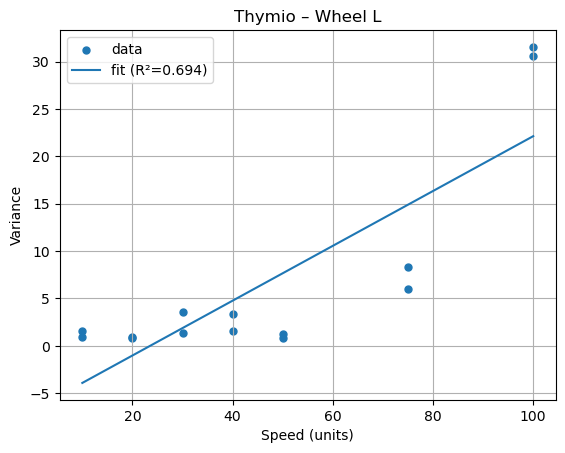 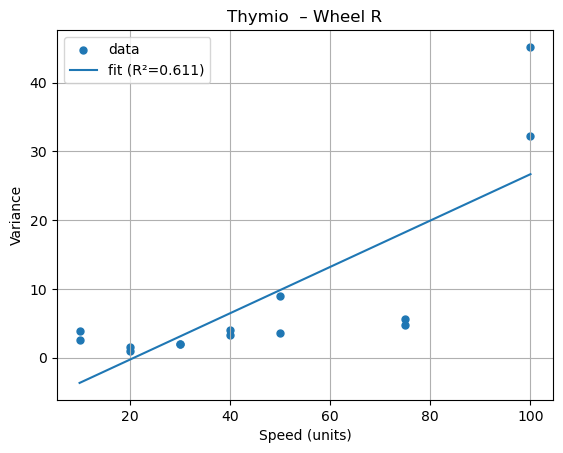